In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import pandas as pd
import numpy as np

from matplotlib import cm
from matplotlib.cm import viridis, plasma

class Database:
    Database = None
    Cursor = None

    def Initialize():
        Database.Database = mysql.connector.connect(
            host="localhost",
            user="WSN",
            password="wsn123", 
            database='WSN4',
            auth_plugin='mysql_native_password'
        )
        
        Database.Cursor = Database.Database.cursor()

    def Execute(query):
            Database.Cursor.execute(query)
            myresult = Database.Cursor.fetchall()
            
            ret = []
            for res in myresult:
                ret.append(res)

            return ret
    
def ListOfTuplesToLists(input):
     return list(map(list, zip(*input)))

Database.Initialize()

In [14]:

simulation_types = ["FFTDMA, RRTDMA"]

def bar_plot(ax, x_data, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars    

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

    plt.xticks(range(len(x_data)), x_data)



def PlotWSN(simulation_id):
    pos_x, pos_y, parent, level, color = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.PosX, SensorNode.PosY, SensorNode.Parent, SensorNode.Level_, SensorNode.Color from 
                       SensorNode where SensorNode.SimulationID = {simulation_id}'''))
    #SN_colors = [(0.0, 1.0, 0.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.5, 0.0, 0.5, 1.0), (0.0, 0.5, 0.5, 1.0)]
    #SN_colors = [(i / (max(color)), 1.0 - (i / (max(color))), i / (max(color)), 1) for i in range(max(color) + 1)]
    SN_colors = [plasma(float(i)/(max(color) + 1)) for i in range(max(color) + 1)]
    print(color)
    print(max(color))

    fig, ax = plt.subplots()

    ax.set_title(f'Sensor Node Locations')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    for x in range(len(pos_x)):
        if parent[x] != -1:
            ax.plot([pos_x[parent[x]], pos_x[x]], [pos_y[parent[x]], pos_y[x]], c=(0.7411764706, 0.7411764706, 0.7411764706, 1.0), zorder=-1)
        else:
            ax.plot([0, pos_x[x]], [0, pos_y[x]], c=(0.7411764706, 0.7411764706, 0.7411764706, 1.0),zorder=-1)
    for x in range(len(pos_x)):
        ax.scatter(pos_x[x], pos_y[x], c=SN_colors[color[x]], zorder=1)
    ax.scatter([0], [0], c=(1.0, 0.0, 0.0, 1.0), zorder=1)

    for i in [50, 100, 150]:
        ax.add_artist(plt.Circle( (0.0, 0.0 ), i, fill = False ))

    #plt.legend(['Sensor Node Location'])
    plt.show()



def PlotCorrelationATD_MTBF():
    #x, y = ListOfTuplesToLists(Database.Execute(f'''select Simulation.FailureMean, Simulation.ActualTotalDuration from 
    #                   Simulation where Simulation.FailureDistributionType = 'Exponential' '''))
    
    #dicti = {'MTBF' : x, 'CWSNEfficiency' : y}
    #df = pd.DataFrame(dicti)
    #sns.regplot(x='MTBF', y='CWSNEfficiency', data=df)

    def plot3d(distributionType):
        x, y, z = ListOfTuplesToLists(Database.Execute(f'''select Simulation.FailureMean, Simulation.FailureStddev, Simulation.ActualTotalDuration from 
                       Simulation where Simulation.FailureDistributionType = '{distributionType}' order by Simulation.FailureMean, Simulation.FailureStddev'''))
        
        mean_count = ListOfTuplesToLists(Database.Execute(f'''select count(*) from 
                       Simulation where Simulation.FailureDistributionType = '{distributionType}' group by Simulation.FailureMean '''))[0][0]
        stddev_count = ListOfTuplesToLists(Database.Execute(f'''select count(*) from 
                       Simulation where Simulation.FailureDistributionType = '{distributionType}' group by Simulation.FailureStddev '''))[0][0]
        
        x = list(set(list(x)))
        y = list(set(list(y)))
        x.sort()
        y.sort()
        #print(x)
        #print(y)
        print(z)



        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        y,x=np.meshgrid(np.array(y),np.array(x))
        #x = np.array(x)
        #y = np.array(y)
        z=np.reshape(np.array(z),(-1,mean_count))

        #print('this is x\n')
        #print(x)
        #print('this is y\n')
        #print(y)
        #print('this is z\n')
        #print(z)

        ax.set_xlabel('FailureMean')
        ax.set_ylabel('FailureStddev')
        ax.set_zlabel('ActualTotalDuration')

        my_col = cm.jet(z/np.amax(z))
        surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm)
        ax.set_zlim(8000000, 10000000)
        #ax.zaxis.set_major_locator(LinearLocator(10))
        #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        #ax.xaxis.set_major_formatter(FuncFormatter(format_log))
        #ax.yaxis.set_major_formatter(FuncFormatter(format_log))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()
        
    for distributionType in ['Weibull', 'Gamma', 'Lognormal']:
    #for distributionType in ['Weibull']:
        plot3d(distributionType)




def PlotDelay_Level():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.Level_, sum(SensorNode.SentPacketTotalDelay) / sum(SensorNode.SentPacketCount) 
                                                from SensorNode where SensorNode.Level_ is not null and SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10 group by SensorNode.Level_'''))
    fig, ax = plt.subplots()

    ax.bar(x, y)
    
    ax.set_title(f'Average Packet Delay for Each Level')
    ax.set_xlabel('Level')
    ax.set_ylabel('Average Packet Delay')
    plt.show()

def PlotDeltaOpt_Level():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.Level_, avg(SensorNode.DeltaOpt)
                                                from SensorNode where SensorNode.Level_ is not null and SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10 group by SensorNode.Level_'''))
    fig, ax = plt.subplots()

    ax.bar(x, y)
    
    ax.set_title(f'Average DeltaOpt for Each Level')
    ax.set_xlabel('Level')
    ax.set_ylabel('Average DeltaOpt')
    plt.show()

def PlotEnergy_Level():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.Level_, avg(SensorNode.EnergyConsumed)
                                                from SensorNode where SensorNode.Level_ is not null and SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10 group by SensorNode.Level_'''))
    fig, ax = plt.subplots()

    ax.bar(x, y)
    
    ax.set_title(f'Average Energy Consumption for Each Level')
    ax.set_xlabel('Level')
    ax.set_ylabel('Average Energy Consumption')
    plt.show()

def PlotCorrelationEnergyConsumed_DeltaOpt():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.DeltaOpt, SensorNode.EnergyConsumed from 
                       SensorNode where SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10'''))
    
    dicti = {'DeltaOpt' : x, 'EnergyConsumed' : y}
    df = pd.DataFrame(dicti)
    sns.regplot(x='DeltaOpt', y='EnergyConsumed', data=df)
    print(df.corr())


def PlotCorrelationCollectionTime_DeltaOpt():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.DeltaOpt, SensorNode.CollectionTime from 
                       SensorNode where SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10'''))
    
    dicti = {'DeltaOpt' : x, 'CollectionTime' : y}
    df = pd.DataFrame(dicti)
    sns.regplot(x='DeltaOpt', y='CollectionTime', data=df)
    print(df.corr())


def PlotCorrelationCollectionTotalTime_CWSN():
    x, y = ListOfTuplesToLists(Database.Execute(f'''select Simulation.TotalDurationToBeTransferred / (Simulation.ActualTotalDuration * 100), Simulation.CWSNEfficiency from 
                       Simulation'''))
    
    dicti = {'TotalDurationToBeTransferred / ActualTotalDuration' : x, 'CWSNEfficiency' : y}
    df = pd.DataFrame(dicti)
    sns.regplot(x='TotalDurationToBeTransferred / ActualTotalDuration', y='CWSNEfficiency', data=df)
    print(df.corr())


def PlotDeltaOptDistribution():
    x = ListOfTuplesToLists(Database.Execute(f'''select SensorNode.DeltaOpt from 
                    SensorNode where SensorNode.DeltaOpt < 1500 and SensorNode.DeltaOpt > 10'''))[0]
    plt.hist(x, density=True, bins=30, cumulative=False)  # density=False would make counts
    plt.ylabel('Probability')
    plt.xlabel('DeltaOpt')
    plt.show()

    plt.hist(x, density=True, bins=30, cumulative=True)  # density=False would make counts
    plt.ylabel('Probability')
    plt.xlabel('DeltaOpt')
    plt.show()


def PlotRRTDMA_VS_FTTDMA_ActualTotalDuration_GroupBy_Mean():
    fttdma_atd, rrtdma_atd, mean = ListOfTuplesToLists(Database.Execute(f'''select sum(SimulationFTTDMA.ActualTotalDuration), sum(SimulationRRTDMA.ActualTotalDuration), SimulationFTTDMA.FailureMean from SimulationFTTDMA inner join SimulationRRTDMA where SimulationRRTDMA.SimulationID = SimulationFTTDMA.SimulationID and SimulationFTTDMA.FailureMean is not null group by SimulationFTTDMA.FailureMean'''))

    fig, ax = plt.subplots()
    bar_plot(ax, mean, {"fttdma_atd" : fttdma_atd, "rrtdma_atd": rrtdma_atd})

    ax.set_title(f'Actual Total Duration vs FailureMean')
    ax.set_xlabel('Failure Mean')
    ax.set_ylabel('Actual Total Duration')
    plt.show()


def PlotRRTDMA_VS_FTTDMA_TotalDataSentToBS_GroupBy_Mean():
    fttdma_tds, rrtdma_tds, _, mean = ListOfTuplesToLists(Database.Execute(f'''select avg(tdsf) as TotalDataSent_FTTDMA, avg(tdsr) as TotalDataSent_RRTDMA, avg(tdsf) / avg(tdsr), SimulationFTTDMA.FailureMean from
(select SimulationID as sif, sum(TotalDataSent) as tdsf from SensorNodeFTTDMA group by SimulationID) temp1
inner join
(select SimulationID as sir, sum(TotalDataSent) as tdsr from SensorNodeRRTDMA group by SimulationID) temp2
inner join SimulationFTTDMA
where sif = sir and sif = SimulationFTTDMA.SimulationID and SimulationFTTDMA.FailureMean is not null
group by SimulationFTTDMA.FailureMean;
'''))

    fig, ax = plt.subplots()
    bar_plot(ax, mean, {"fttdma_tds" : fttdma_tds, "rrtdma_tds": rrtdma_tds})

    ax.set_title(f'Total Data Sent vs FailureMean')
    ax.set_xlabel('Failure Mean')
    ax.set_ylabel('Total Data Sent')
    plt.show()

def PlotRRTDMA_VS_FTTDMA_PercentageDataSentToBS_GroupBy_Mean():
    fttdma_pds, rrtdma_pds, _, mean = ListOfTuplesToLists(Database.Execute(f'''select avg(tdsf) / sum(SimulationFTTDMA.ActualTotalDuration) as PercentageDataSent_FTTDMA, avg(tdsr) / sum(SimulationFTTDMA.ActualTotalDuration) as PercentageDataSent_RRTDMA, (avg(tdsf) / sum(SimulationFTTDMA.ActualTotalDuration)) / (avg(tdsr) / sum(SimulationFTTDMA.ActualTotalDuration)) as PercentageDataSent_FTTDMAoverPercentageDataSent_RRTDMA, SimulationFTTDMA.FailureMean from
(select SimulationID as sif, sum(TotalDataSent) as tdsf from SensorNodeFTTDMA group by SimulationID) temp1
inner join
(select SimulationID as sir, sum(TotalDataSent) as tdsr from SensorNodeRRTDMA group by SimulationID) temp2
inner join SimulationFTTDMA
inner join SimulationRRTDMA
where sif = sir and sif = SimulationFTTDMA.SimulationID and SimulationFTTDMA.SimulationID = SimulationRRTDMA.SimulationID and SimulationFTTDMA.FailureMean is not null
group by SimulationFTTDMA.FailureMean;
'''))

    fig, ax = plt.subplots()
    bar_plot(ax, mean, {"fttdma_pds" : fttdma_pds, "rrtdma_pds": rrtdma_pds})

    ax.set_title(f'Percentage Data Sent vs FailureMean')
    ax.set_xlabel('Failure Mean')
    ax.set_ylabel('Percentage Data Sent')
    plt.show()
    

In [15]:
PlotWSN(1)

ProgrammingError: 1146 (42S02): Table 'wsn4.sensornode' doesn't exist

In [ ]:
#PlotCorrelationCWSN_MTBF()

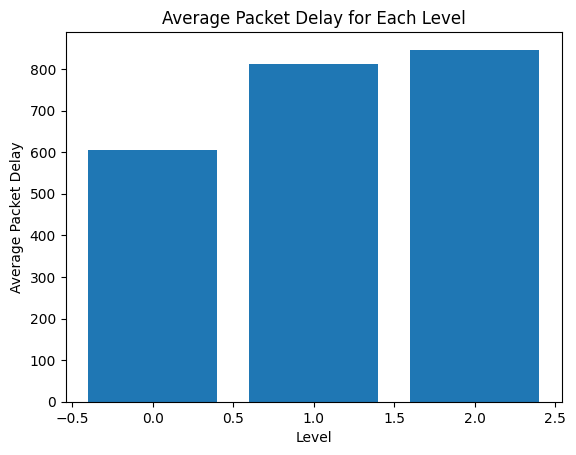

In [ ]:
PlotDelay_Level()

                DeltaOpt  EnergyConsumed
DeltaOpt        1.000000       -0.261988
EnergyConsumed -0.261988        1.000000


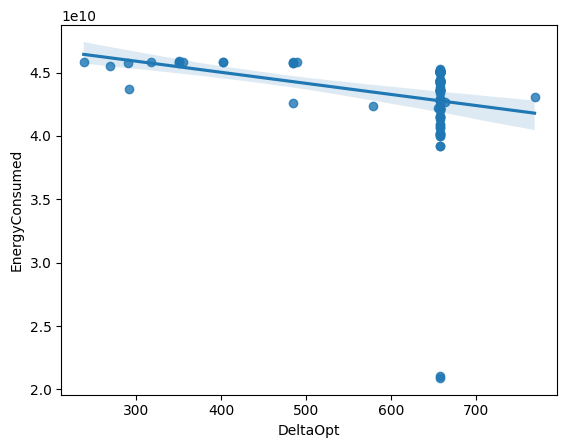

In [ ]:
PlotCorrelationEnergyConsumed_DeltaOpt()

                DeltaOpt  CollectionTime
DeltaOpt        1.000000        0.225677
CollectionTime  0.225677        1.000000


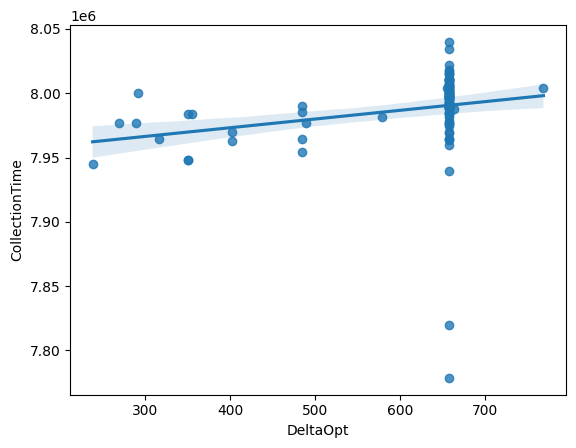

In [ ]:
PlotCorrelationCollectionTime_DeltaOpt()

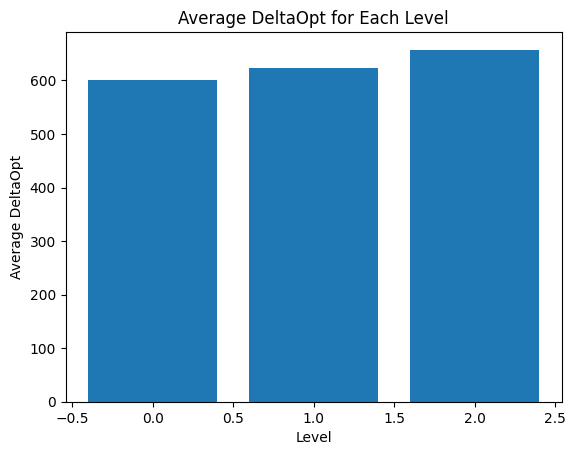

In [ ]:
PlotDeltaOpt_Level()

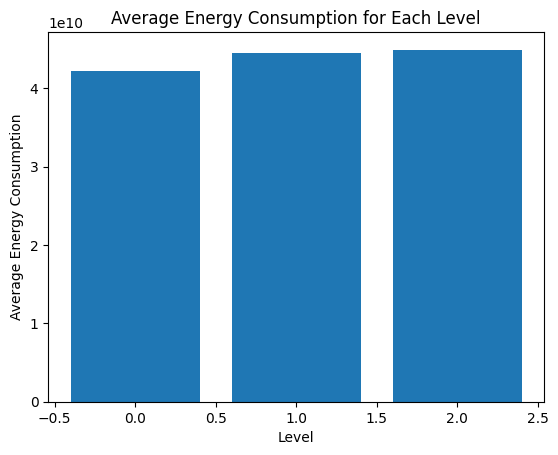

In [ ]:
PlotEnergy_Level()

                                                    TotalDurationToBeTransferred / ActualTotalDuration  \
TotalDurationToBeTransferred / ActualTotalDuration                                                NaN    
CWSNEfficiency                                                                                    NaN    

                                                    CWSNEfficiency  
TotalDurationToBeTransferred / ActualTotalDuration             NaN  
CWSNEfficiency                                                 NaN  


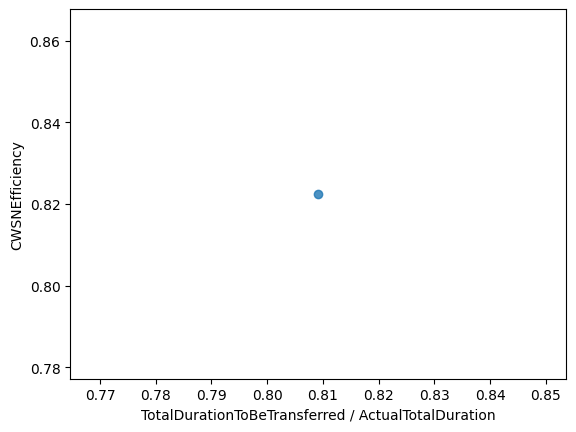

In [ ]:
PlotCorrelationCollectionTotalTime_CWSN()

[9610140.0]


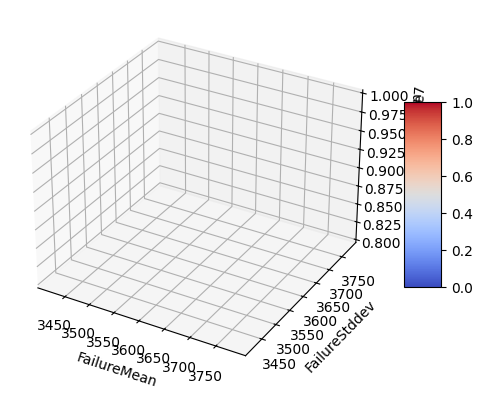

In [ ]:
PlotCorrelationATD_MTBF()

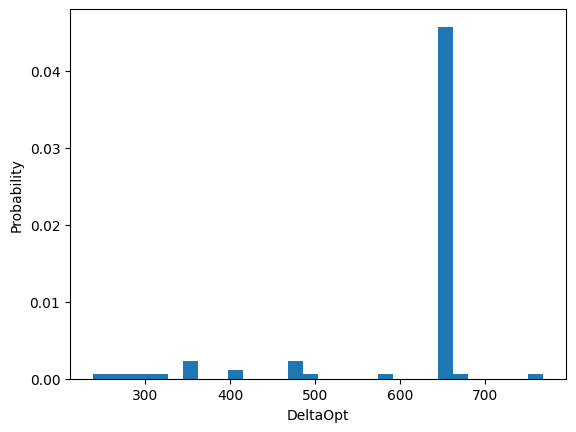

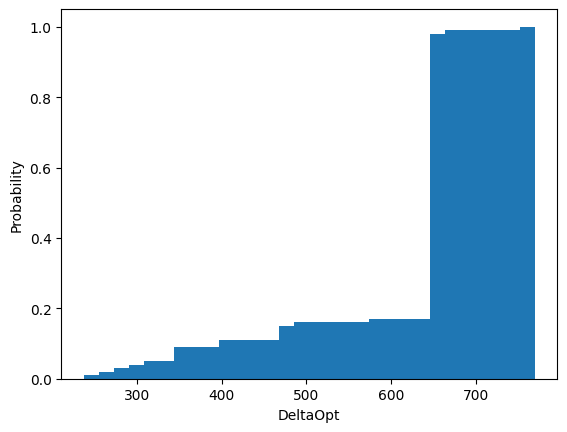

In [ ]:
PlotDeltaOptDistribution()

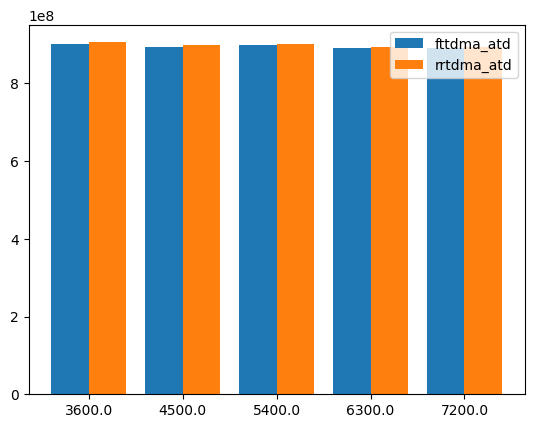

In [ ]:
PlotRRTDMA_VS_FTTDMA_ActualTotalDuration_GroupBy_Mean()

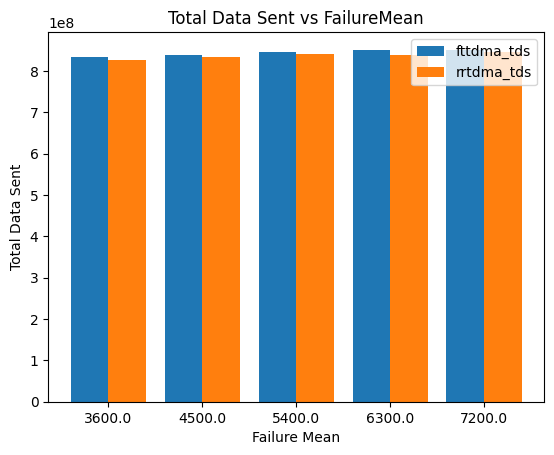

In [ ]:
PlotRRTDMA_VS_FTTDMA_TotalDataSentToBS_GroupBy_Mean()

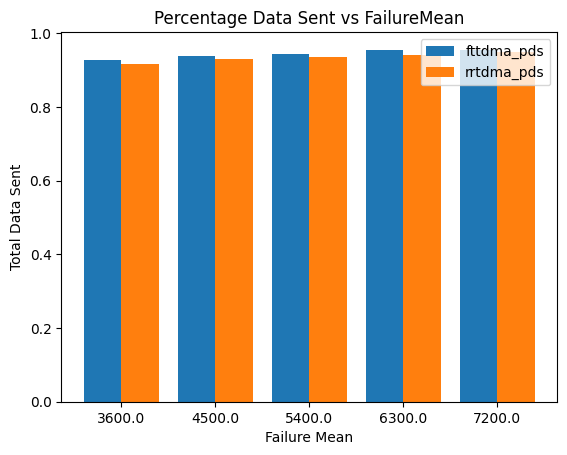

In [ ]:
PlotRRTDMA_VS_FTTDMA_PercentageDataSentToBS_GroupBy_Mean()